# DCGAN

## Set global variable

In [1]:
# Path to dataset
# DATASET = "dataset/cats/"
DATASET = "dataset/lfw/"
DATASET_NAME = DATASET.rstrip('/').split('/')[-1]

# Hyperparameter for training
IMG_SIZE = 64
CHANNELS_IMG = 3
BATCH_SIZE = 16
LATENT_DIM = 100
FEATURES_DISC = 64
FEATURES_GEN = 64
LEARNING_RATE = 1e-4  #0.0001
# LEARNING_RATE = 1e-5  #0.00001
NUM_EPOCHS = 100

## Count and set number of image variable

In [2]:
import os
import glob

def count_image_files(folder_path, extensions=['.jpg', '.jpeg', '.png', '.gif']):
    count = 0
    for extension in extensions:
        search_pattern = os.path.join(folder_path, '*' + extension)
        count += len(glob.glob(search_pattern))
    return count

NUM_IMAGES = count_image_files(DATASET)

print(f"Number of image files in {DATASET}: {NUM_IMAGES}")


Number of image files in dataset/lfw/: 12876


## Set agnostic code

In [3]:
import torch

# agnostic code to detect the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Show the data

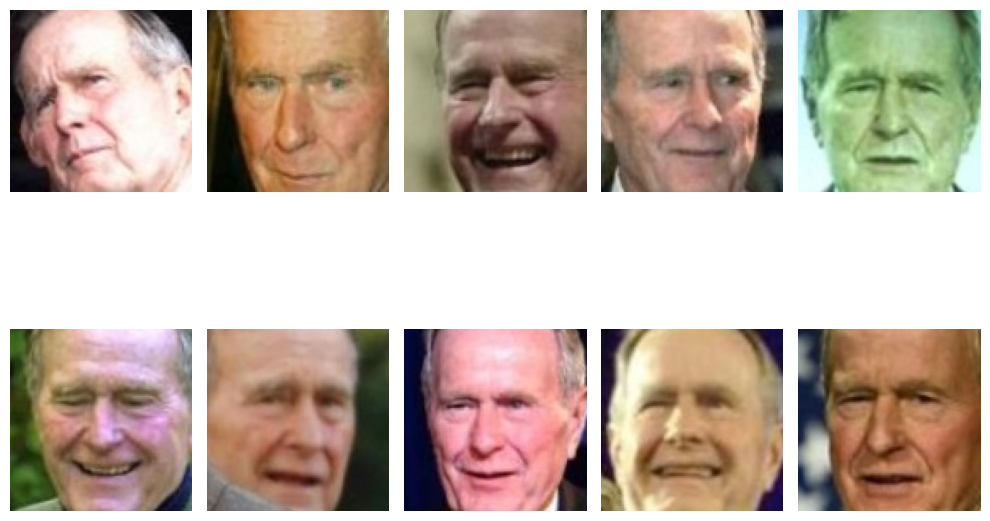

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Get the list of image filenames
image_filenames = os.listdir(DATASET)

# Set the number of images to plot
num_images = 10

# Create a new figure with multiple subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 8))

# Iterate over the first num_images filenames and plot the corresponding images
for i, filename in enumerate(image_filenames[:num_images]):
    # Load the image
    img_path = os.path.join(DATASET, filename)
    img = Image.open(img_path)

    # Convert the image to a numpy array
    img_arr = np.asarray(img)

    # Plot the image on the corresponding subplot
    row = i // 5
    col = i % 5
    axes[row, col].imshow(img_arr, cmap='gray')
    axes[row, col].axis('off')

# Adjust the spacing of the figure
fig.tight_layout()

# Show the figure
plt.show()


## Load images to tensor and normalize images

In [5]:
import torchvision.transforms as transforms
from PIL import Image

# Get the list of image filenames
image_filenames = os.listdir(DATASET)

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # convert PIL image to tensor and scales data into [0,1] 
    # transforms.Lambda(lambda t: (t * 2) - 1) # Scale between [-1, 1] 
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), # Scale between [-1, 1] by (input[channel] - mean[channel]) / std[channel]
])

# Create a list to store the transformed images
transformed_images = []

# Iterate over the first num_images filenames and transform the corresponding images
for i, filename in enumerate(image_filenames[:NUM_IMAGES]):
    # Load the image
    img_path = os.path.join(DATASET, filename)
    image = Image.open(img_path)

    # Apply the transformations
    transformed_image = transform(image)

    # Append the transformed image to the list
    transformed_images.append(transformed_image)

# Convert the list of transformed images to a PyTorch tensor
transformed_images = torch.stack(transformed_images)

print(f'Loaded data: {transformed_images.shape}')

Loaded data: torch.Size([12876, 3, 64, 64])


## Separate batch size

In [6]:
from torch.utils.data import DataLoader

data_loader = DataLoader(transformed_images, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# print first batch.shape
data_iter = iter(data_loader)
print(next(data_iter).shape)

torch.Size([16, 3, 64, 64])


## Train model and save weight and log 

### define save weight function

In [7]:
def save_weight(model, epoch, out_path=f"weights/{DATASET_NAME}/DCGAN",prefix=""):
    """Save weight to xxx.pt file"""
    os.makedirs(out_path, exist_ok=True)
    torch.save(model.state_dict(), f'{out_path}{prefix}{epoch}.pt')

### Training process
parameter base on DCGAN paper https://arxiv.org/abs/1511.06434
except learning rate

In [8]:
import time
from modules.dcgan import Discriminator, Generator, initialize_weights
import torch.optim as optim
import torch.nn as nn
import torchvision

from torch.utils.tensorboard import SummaryWriter

gen = Generator(LATENT_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

# init weight
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(32, LATENT_DIM, 1, 1).to(device)

writer = SummaryWriter(f'logs/{DATASET_NAME}/DCGAN')

step = 0

time_use = 0

for epoch in range(NUM_EPOCHS):

    lossG = 0
    lossD = 0

    gen.train()
    disc.train()


    # use time for time measurement
    start_time = time.time()
    
    for batch_idx, real in enumerate(data_loader):
        real = real.to(device)
        noise = torch.randn(BATCH_SIZE, LATENT_DIM, 1, 1).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # sum loss
        lossG += loss_gen
        lossD += loss_disc

        # # Print losses occasionally and print to tensorboard
        if batch_idx % BATCH_SIZE == 0:
            step += 1

        if epoch == 0 and batch_idx == 0:
            meanG_loss = lossG / BATCH_SIZE
            meanD_loss = lossD / BATCH_SIZE

            writer.add_scalar('Loss/loss_disc', lossD, epoch)
            writer.add_scalar('Loss/loss_gen', lossG, epoch)
            writer.add_scalar("traing time", time_use, epoch)

    end_time = time.time()
    epoch_time = end_time - start_time

    time_use += epoch_time 

    epoch_index = epoch+1

    # calculate mean value
    meanG_loss = lossG / len(data_loader.dataset)
    meanD_loss = lossD / len(data_loader.dataset)

    message = f'''Epoch: {epoch_index}, Using Time: {epoch_time:.4f}, Loss D: {meanD_loss:.4f}, Loss G: {meanG_loss:.4f}'''

    # save weight of models
    save_weight(gen, epoch+1, out_path=f"weights/{DATASET_NAME}/DCGAN/", prefix="G")
    save_weight(disc, epoch+1, out_path=f"weights/{DATASET_NAME}/DCGAN/", prefix="D")

    print(
        f"Epoch [{epoch_index}/{NUM_EPOCHS}] Batch {batch_idx+1}/{len(data_loader)} Using Time: {epoch_time:.4f}\
            Loss D: {meanD_loss:.4f}, loss G: {meanG_loss:.4f}"
    )

    # tensorboard
    writer.add_scalar('Loss/loss_disc', meanD_loss, epoch_index)
    writer.add_scalar('Loss/loss_gen', meanG_loss, epoch_index)
    writer.add_scalar("traing time", time_use, epoch_index)

    gen.eval
    with torch.no_grad():
        fake = gen(fixed_noise)
        # take out (up to) 32 examples
        # img_grid_real = torchvision.utils.make_grid(real[:32], normalize=True)
        # writer.add_image("All/Real", img_grid_real, global_step=epoch_index)

        img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
        writer.add_image("All/Fake", img_grid_fake, global_step=epoch_index)


/home/nice/mambaforge/lib/python3.10/site-packages/torch/nn/modules/conv.py:956: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv_transpose2d(


Epoch [1/100] Batch 804/804 Using Time: 113.6763            Loss D: 0.0237, loss G: 0.1360
Epoch [2/100] Batch 804/804 Using Time: 105.1455            Loss D: 0.0304, loss G: 0.1249
Epoch [3/100] Batch 804/804 Using Time: 106.2311            Loss D: 0.0274, loss G: 0.1432
Epoch [4/100] Batch 804/804 Using Time: 107.1709            Loss D: 0.0281, loss G: 0.1369
Epoch [5/100] Batch 804/804 Using Time: 107.8662            Loss D: 0.0277, loss G: 0.1331
Epoch [6/100] Batch 804/804 Using Time: 108.2417            Loss D: 0.0267, loss G: 0.1329
Epoch [7/100] Batch 804/804 Using Time: 108.6899            Loss D: 0.0253, loss G: 0.1410
Epoch [8/100] Batch 804/804 Using Time: 108.7689            Loss D: 0.0257, loss G: 0.1361
Epoch [9/100] Batch 804/804 Using Time: 109.0065            Loss D: 0.0248, loss G: 0.1372
Epoch [10/100] Batch 804/804 Using Time: 109.2637            Loss D: 0.0253, loss G: 0.1344
Epoch [11/100] Batch 804/804 Using Time: 108.9200            Loss D: 0.0251, loss G: 0.13

# Measure FID

use this implementation: https://github.com/mseitzer/pytorch-fid/tree/master

You need to import model first  
and masure define gen_log function

## define FID measurement function 

In [7]:
import subprocess
import torch
from torchvision.utils import save_image
import re
import os
import gc

# Create a function to run the FID script
def run_fid(real_path, gen_path):
    command = ["python", "-m", "pytorch_fid", real_path, gen_path]

    output = subprocess.run(command, capture_output=True, text=True)

    # Extract the FID score using regular expressions
    output = output.stdout

    fid_score_match = re.search(r"FID:\s+(-?\d+\.\d+)", output)
    
    if fid_score_match:
        fid_score = float(fid_score_match.group(1))
        
        return fid_score

    else:
        print("FID score not found in the output.")

def generate_images(model, sample_size=100*8, batch_size=8, device="cuda", real_path=f"dataset/{DATASET_NAME}/", gen_path=f"generated_images/{DATASET_NAME}/DCGAN"):
    # Set the model to evaluation mode
    model.eval()

    # Create a folder for generated images if it doesn't exist
    os.makedirs(gen_path, exist_ok=True)

    # Generate images
    with torch.no_grad():
        for i in range(0, sample_size, batch_size):
            
            # Random value from the normal distribution
            z = torch.randn(batch_size, LATENT_DIM, 1, 1).to(device)

            # Random from uniform distribution in range [-2, 2]
            # z = torch.FloatTensor(batch_size, LATENT_DIM, 1, 1).uniform_(-2, 2).to(device)

            # Generate images
            gen_imgs = model(z)

            # Save images
            for j in range(batch_size):
                save_image(gen_imgs[j], f"{gen_path}/{i+j}.png", normalize=True)

    # model = None
    # gc.collect() 

    with torch.no_grad():
        del model
        torch.cuda.empty_cache()


## Load weight of model to measure FID score

In [8]:
def load_weight( generator, discriminator=None, weight_path=f"weights/{DATASET_NAME}/DCGAN", index=int):
    # Load the saved weights
    generator.load_state_dict(torch.load(f'{weight_path}/G{index}.pt'))
    # discriminator.load_state_dict(torch.load(f'{weight_path}/D{index}.pt'))
    

In [9]:
from modules.dcgan import Generator
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(f'logs/{DATASET_NAME}/DCGAN/')

# Get the list of files ending with ".pth"
# file_list = list(directory_path.glob('*.pt'))

sample_size = 10000

start = 1
stop = NUM_EPOCHS+1

for i in range(start, stop):
    
    index_weight = i

    gen = Generator(LATENT_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
    
    load_weight(generator=gen, weight_path=f'weights/{DATASET_NAME}/DCGAN/', index=index_weight)

    # print(f'gen/{DATASET_NAME}/DCGAN/{index_weight}')
    # generate_images(gen, sample_size, batch_size=16, device=f'{device}', gen_path=f'gen/{DATASET_NAME}/DCGAN/{index_weight}')
    fid_score = run_fid(f"{DATASET}", f"gen/{DATASET_NAME}/DCGAN/{index_weight}")
    # fid_score = FID_measure(gen, sample_size, batch_size=16, device=f"{device}", gen_path=f"gen/{DATASET_NAME}/DCGAN/{index_weight}")   
    print(f'Epoch: {index_weight} FID score: {fid_score}')

    writer.add_scalar("Metrics/FID Score", fid_score, index_weight)


Epoch:  1
FID score: 302.84416722395554
Epoch:  2
FID score: 267.88380370701987
Epoch:  3
FID score: 221.30047846774755
Epoch:  4
FID score: 158.78525848689102
Epoch:  5
FID score: 125.98178431262221
Epoch:  6
FID score: 100.6179301711646
Epoch:  7
FID score: 107.75938130555437
Epoch:  8
FID score: 85.27779200464121
Epoch:  9
FID score: 94.28900934140088
Epoch:  10
FID score: 78.88324288274927
Epoch:  11
FID score: 81.2906671995031
Epoch:  12
FID score: 78.69907387510122
Epoch:  13
FID score: 69.529313145543
Epoch:  14
FID score: 68.69202690419087
Epoch:  15
FID score: 61.1427721596483
Epoch:  16
FID score: 64.43960854612632
Epoch:  17
FID score: 61.59413489759214
Epoch:  18
FID score: 55.141855965226085
Epoch:  19
FID score: 53.86659576585484
Epoch:  20
FID score: 51.07548076224569
Epoch:  21
FID score: 48.40488084045057
Epoch:  22
FID score: 47.262972213054695
Epoch:  23
FID score: 50.93912348557228
Epoch:  24
FID score: 49.20587685533778
Epoch:  25
FID score: 51.18515260146151
Epoch

# Count learnable parameter in model

In [ ]:
gen = Generator(LATENT_DIM, CHANNELS_IMG, FEATURES_GEN).to("cuda")
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to("cuda")

gen_total_params = sum(p.numel() for p in gen.parameters() if p.requires_grad)
disc_total_params = sum(p.numel() for p in disc.parameters() if p.requires_grad)

print(gen_total_params+disc_total_params)

15424068
